In [363]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, './pyLDLE2/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [483]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf, erfinv
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from scipy.stats import chi2

from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import graphlearning as gl

import bx_util

In [485]:
data, labels = gl.datasets.load('mnist', metric='raw')

In [486]:
top_digits = []
bottom_digits = []
ds = []
for digit in tqdm(range(10)):
    digit_idx = labels == digit
    data_digit = data[digit_idx]
    labels_digit = labels[digit_idx]
    X = data_digit

    pca = PCA(n_components=100)
    y = pca.fit_transform(X)
    X = pca.inverse_transform(y)
    
    opts = bx_util.default_opts
    opts['k_nn'] = 256
    opts['k_tune'] = 256
    opts['ds'] = True
    opts['s'] = 0.01
    opts['local_pca'] = True
    opts['d'] = 2
    bx_ds, bx_init_ds, K_ds, D_ds = bx_util.estimate_bx(X, opts=opts, ret_K_D = True)
    
    k = 50
    sortind = np.argsort(bx_ds)
    topk = sortind[-k:]
    bottomk = sortind[:k]
    
    top_digits.append(topk)
    bottom_digits.append(bottomk)
    ds.append(bx_ds)

  0%|          | 0/10 [00:00<?, ?it/s]

h: 2.36329000269012


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 943
s: 0.01


  0%|          | 0/6903 [00:00<?, ?it/s]

h: 1.0902294544041762


  0%|          | 0/10000 [00:00<?, ?it/s]

s: 0.01


  0%|          | 0/7877 [00:00<?, ?it/s]

h: 2.7155145396456537


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 693
s: 0.01


  0%|          | 0/6990 [00:00<?, ?it/s]

h: 2.406299287744898


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 704
s: 0.01


  0%|          | 0/7141 [00:00<?, ?it/s]

h: 2.3102785831431336


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 990
s: 0.01


  0%|          | 0/6824 [00:00<?, ?it/s]

h: 2.4486287431303078


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 1360
s: 0.01


  0%|          | 0/6313 [00:00<?, ?it/s]

h: 2.2360336337268207


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 1572
s: 0.01


  0%|          | 0/6876 [00:00<?, ?it/s]

h: 1.8988796404367065


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 1529
s: 0.01


  0%|          | 0/7293 [00:00<?, ?it/s]

h: 2.4605709592879252


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 1793
s: 0.01


  0%|          | 0/6825 [00:00<?, ?it/s]

h: 2.1109968949638276


  0%|          | 0/10000 [00:00<?, ?it/s]

Sinkhorn converged at iter: 2242
s: 0.01


  0%|          | 0/6958 [00:00<?, ?it/s]

In [408]:
bdstop = []
bdsbottom = []

for digit in tqdm(range(10)):
    digit_idx = labels == digit
    data_digit = data[digit_idx]
    labels_digit = labels[digit_idx]
    X = data_digit
    digits = X[bottom_digits[digit][:15]]
    bdsbottom.append(np.concatenate([digits, 
                               np.mean(X[bottom_digits[digit]], axis=0, keepdims=True)]))
    
    digits = X[bottom_digits[digit][-15:]]
    bdstop.append(np.concatenate([digits, 
                               np.mean(X[top_digits[digit]], axis=0, keepdims=True)]))

  0%|          | 0/10 [00:00<?, ?it/s]

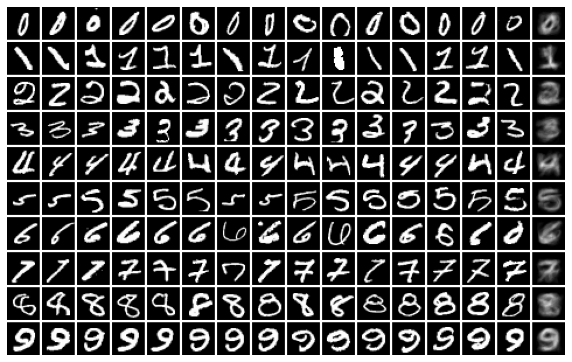

In [409]:
gl.utils.image_grid(np.concatenate(bdstop,axis=0), n_rows=10, n_cols=16, transpose=False)

In [ ]:
gl.utils.image_grid(np.concatenate(bdsbottom,axis=0), n_rows=10, n_cols=16, transpose=False)

In [410]:
Xordered = []
yordered = []
for digit in tqdm(range(10)):
    digit_idx = labels == digit
    data_digit = data[digit_idx]
    labels_digit = labels[digit_idx]
    X = data_digit
    yordered.append(labels_digit)
    
    Xordered.append(X)

  0%|          | 0/10 [00:00<?, ?it/s]

In [493]:
import umap
reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(np.concatenate(Xordered, axis=0))

/home/chester/miniconda3/envs/ml-general/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [494]:
embedding.shape

(70000, 2)

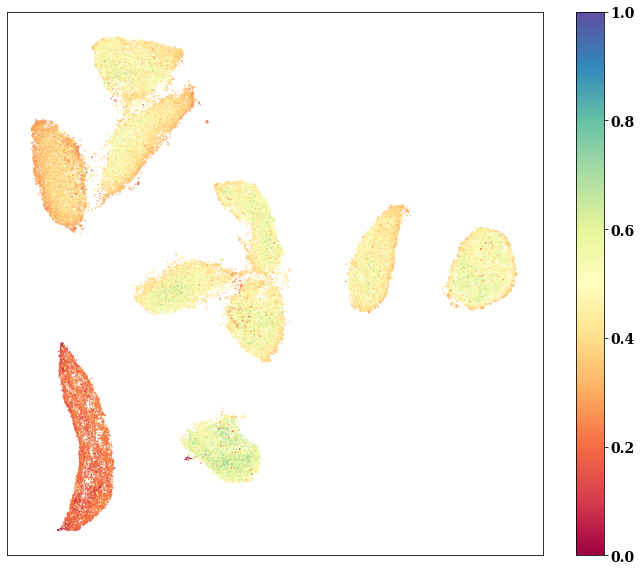

In [495]:
fig, ax = plt.subplots(figsize=(12, 10))
tildeds = np.concatenate(ds)
color = (tildeds - tildeds.min()) / (tildeds.max() - tildeds.min())
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.9)
plt.setp(ax, xticks=[], yticks=[])
plt.title("", fontsize=18)
plt.colorbar()
plt.show()

In [496]:
ps = []
for tilded in ds:
    p = np.percentile(tilded, 20, axis=0)
    pidx = tilded < p
    ps.append(pidx)
pidx = np.concatenate(ps)

/tmp/ipykernel_30030/3848051913.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[digit_idx, 0][pidx], embedding[digit_idx, 1][pidx], c='r', cmap="Spectral", s=1)


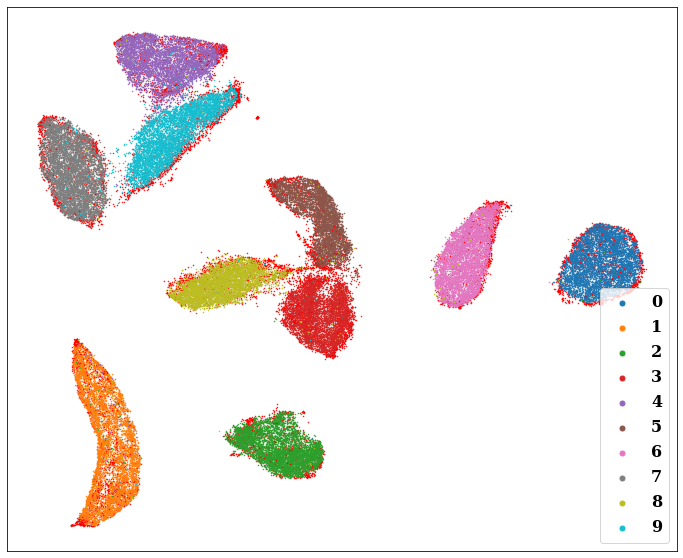

In [497]:
fig, ax = plt.subplots(figsize=(12, 10))

for i in range(10):
    digit_idx = np.concatenate(yordered) == i
    p = np.percentile(ds[i], 20, axis=0)
    pidx = ds[i] < p
    plt.scatter(embedding[digit_idx, 0][pidx], embedding[digit_idx, 1][pidx], c='r', cmap="Spectral", s=1)
    plt.scatter(embedding[digit_idx, 0][~pidx], embedding[digit_idx, 1][~pidx], label=i, s=1)    

plt.setp(ax, xticks=[], yticks=[])
plt.title("", fontsize=18)
plt.legend(loc='best',markerscale=10)
plt.show()